<a href="https://colab.research.google.com/github/Natural-Language-Processing-YU/Exercises/blob/main/M8_Vanilla_RNN_Stock_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Libraries

In this step, we import the necessary libraries. We'll use Pandas for data manipulation, NumPy for numerical computations, Scikit-learn's MinMaxScaler for data normalization, PyTorch for building the RNN model, and DataLoader and TensorDataset for handling data during training.




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


#Step 2: Load and Prepare Data


Here, we load the tabular data into a Pandas DataFrame. We extract the 'Close' prices, which will be our target variable for prediction. We then use MinMaxScaler to normalize the closing prices between 0 and 1, which is essential for training the neural network.

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Natural-Language-Processing-YU/Exercises/main/data/StockData.csv')
display(stock_data)
print("Information about the dataset", end = "\n")
print(stock_data.info())

closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(closing_prices)


# Step 3: Define Time Steps and Create Input Sequences
In this step, we define the number of time steps (days) to use for prediction. We then create input sequences 'X_train' and corresponding labels 'y_train' for prediction. The 'X_train' sequences are formed by taking 'time_steps' number of closing prices as input, and the 'y_train' labels are the closing prices for the next time step. We convert the sequences to PyTorch tensors.




In [ ]:
time_steps = 5
X_train, y_train = [], []
for i in range(time_steps, len(scaled_prices)):
    X_train.append(scaled_prices[i - time_steps:i, 0])
    y_train.append(scaled_prices[i, 0])
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)


<ipython-input-3-7c22b8245220>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)


#Step 4: Reshape Input Data for Vanilla RNN
Here, we reshape the input data 'X_train' to match the expected format for the vanilla RNN, which is (batch_size, time_steps, input_size). In this case, 'input_size' is 1, as we have a single feature (closing price) for each time step.




In [ ]:
X_train = X_train.view(X_train.shape[0], X_train.shape[1], 1)


#Step 5: Build the Vanilla RNN Model

Here, we define the VanillaRNN model as a PyTorch Module. The model consists of an nn.RNN layer, which is a vanilla RNN layer, followed by a fully connected nn.Linear layer. The forward method defines how the data flows through the layers of the model. We initialize the model with input size, hidden size, number of layers, and output size.




In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  # Add num_layers attribute
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = VanillaRNN(input_size, hidden_size, num_layers, output_size)


#Step 6: Define Loss Function and Optimizer


In this step, we define the Mean Squared Error (MSE) loss function as the criterion for regression tasks. We use the Adam optimizer to update the model's parameters during training.



In [ ]:
criterion = nn.MSELoss()

lr=0.02
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


#Step 7: Train the Model
In this step, we train the Vanilla RNN model using the training data. We use DataLoader to create batches of data for each training iteration. For each epoch, we iterate through the data batches, calculate the model's output, compute the loss, and perform backpropagation to update the model's parameters.




In [ ]:
num_epochs = 30
batch_size = 32

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

losses = []  # To store the loss for plotting
learning_rates = []  # To store the learning rates for plotting


for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)  # Accumulate the total loss for the epoch

    # Calculate the average loss for the epoch
    epoch_loss /= len(dataset)
    # Store the loss and learning rate for plotting
    losses.append(epoch_loss)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    # Print the loss for every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/30], Loss: 0.044910
Epoch [20/30], Loss: 0.048802
Epoch [30/30], Loss: 0.043768


## Plot the loss

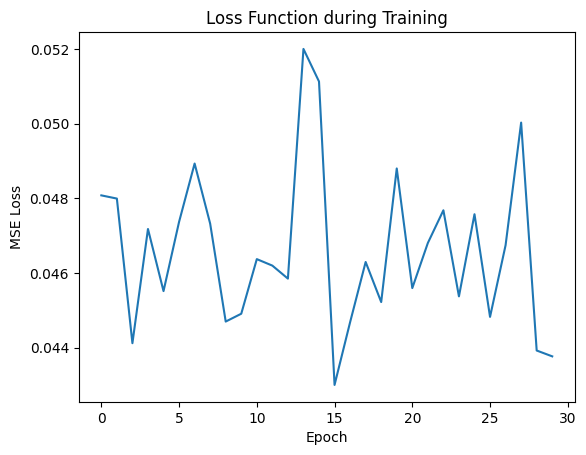

In [ ]:
import matplotlib.pyplot as plt

# Plot the loss function
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Function during Training')
plt.show()

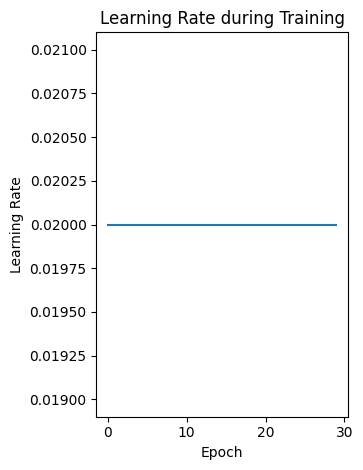

In [ ]:
# Plot the learning rate
plt.subplot(1, 2, 2)
plt.plot(learning_rates)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate during Training')

plt.tight_layout()
plt.show()

# Step 8: Make Predictions

Finally, we use the trained model to make predictions on the training data. We set the model in evaluation mode using model.eval()







In [ ]:
with torch.no_grad():
    model.eval()
    predictions = model(X_train.float()).numpy()
    predictions = scaler.inverse_transform(predictions)


In [ ]:
print("Predicted Closing Prices:")
for prediction in predictions:
    print(prediction[0])

Streaming output truncated to the last 5000 lines.
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.1105
181.